# Compare 2 Surf En

In [9]:
%config InlineBackend.figure_formats = ['svg']
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

from calculations import observables as calc
from calculations import triangular as tri
from manage import utils

sns.set_theme()

###

data_dirs = [
    "/home/max/projects/apfc/data/line1dn03",
    "/home/max/projects/apfc/data/line1dn02"
]

surf_en_indeces = [10, -1]

names = ["const n0=0", "const n0=-0.03"]

colors = ["r", "b"]
line_widths = [1, 0.5]

normalize = False

const n0=0 eps: -0.0028, gamma0: 0.3993
const n0=-0.03 eps: 0.0274, gamma0: 0.2202


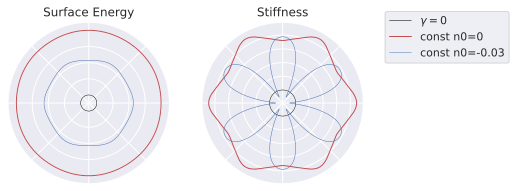

In [10]:
def fill(arr, div, add=False):

    max_ = np.max(arr)

    o_arr = arr.copy()[1:]
    do_add_int = int(add)

    for i in range(1, div):
        add_arr = do_add_int * i * max_
        arr = np.hstack([arr, o_arr + add_arr])

    return arr


def norm(arr):
    ret = arr - np.min(arr)
    return ret / np.max(ret) 

configs = []
thetas = []
thetas_str = []
surf_ens = []
stiffs = []

for data_dir in data_dirs:

    ### Config ###

    config_path = f"{data_dir}/config.json"
    with open(config_path, "r") as f:
        config = json.load(f)

    ### Surf En ###

    surf_en = pd.read_csv(f"{data_dir}/surf_en.csv", index_col=0)
    surf_en = surf_en.apply(pd.to_numeric)

    ### Thetas ###

    theta_str = surf_en.columns.to_numpy()
    theta = utils.get_thetas(config)

    ### stiffness ###

    orig_theta_len = theta.shape[0]
    stiff = pd.DataFrame(columns=surf_en.columns, index=surf_en.index)

    for i, row in surf_en.iterrows():

        surf_row = row.to_numpy().copy()
        surf_row = fill(surf_row, 3)

        stiff_row = calc.calc_stiffness(surf_row, theta)

        stiff.loc[i, :] = stiff_row[orig_theta_len - 1 : 2 * orig_theta_len - 1]

    ### Fill ###

    div = config["thetaDiv"]
    theta = fill(theta, div, True)

    ### Appends ###
    
    configs.append(config)
    surf_ens.append(surf_en)
    thetas.append(theta)
    thetas_str.append(theta_str)
    stiffs.append(stiff)

###

fig = plt.figure()
ax_surf = plt.subplot(121, projection="polar")
ax_stiff = plt.subplot(122, projection="polar")

ax_surf.set_aspect("equal")
ax_stiff.set_aspect("equal")

plot_stiff = []
plot_surf = []
surf_lim = [0., 0.]
stiff_lim = [0., 0.]
for i in range(len(surf_ens)):

    surf = fill(surf_ens[i].iloc[surf_en_indeces[i], :], configs[i]["thetaDiv"])
    stiff = fill(stiffs[i].iloc[surf_en_indeces[i], :], configs[i]["thetaDiv"])

    if normalize:

        surf = norm(surf)
        stiff = norm(stiff)

    plot_stiff.append(stiff)
    plot_surf.append(surf)

    surf_lim[0] = np.min([surf_lim[0], np.min(surf)])
    stiff_lim[0] = np.min([stiff_lim[0], np.min(stiff)])

    surf_lim[1] = np.max([surf_lim[1], np.max(surf)])
    stiff_lim[1] = np.max([stiff_lim[1], np.max(stiff)])

add_lim = 0.05

surf_lim[1] += add_lim
stiff_lim[1] += add_lim

surf_lim[0] -= add_lim
stiff_lim[0] -= add_lim

if surf_lim[0] < 0 < surf_lim[1]:
    ax_surf.plot(thetas[0], np.zeros(thetas[0].shape), c="black", lw=0.5)

if stiff_lim[0] < 0 < stiff_lim[1]:
    ax_stiff.plot(thetas[0], np.zeros(thetas[0].shape), c="black", label="$\\gamma=0$", lw=0.5)

for i in range(len(plot_surf)):

    ax_surf.plot(thetas[i], plot_surf[i], c=colors[i], label=names[i], lw=line_widths[i])
    ax_stiff.plot(thetas[i], plot_stiff[i], c=colors[i], label=names[i], lw=line_widths[i])

    eps, gamma0 = tri.fit_surf_en(thetas[i], plot_surf[i])
    print(names[i], f"eps: {eps:.4f}, gamma0: {gamma0:.4f}")

ax_surf.set_title("Surface Energy")
ax_stiff.set_title("Stiffness")
ax_stiff.legend(bbox_to_anchor=(1.1, 1.1))

ax_surf.set_xticklabels([])
ax_surf.set_yticklabels([])
ax_stiff.set_xticklabels([])
ax_stiff.set_yticklabels([])

ax_surf.set_ylim(surf_lim)
ax_stiff.set_ylim(stiff_lim)

plt.show()

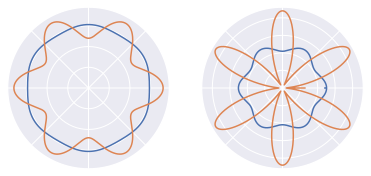

In [146]:
x = np.linspace(0, 2 * np.pi, 10000)

y1 = calc.theo_surf_en(x, -0.02, 0.3)
y2 = calc.theo_surf_en(x, 0.2, 0.3)

stiff1 = calc.calc_stiffness(y1, x)
stiff2 = calc.calc_stiffness(y2, x)

plt.figure()
ax = plt.subplot(121, projection="polar")
ax2 = plt.subplot(122, projection="polar")
ax.set_aspect("equal")
ax2.set_aspect("equal")
ax.plot(x, y1, label="y1")
ax.plot(x, y2, label="y2")
ax2.plot(x, stiff1, label="y1")
ax2.plot(x, stiff2, label="y2")

ax.set_xticklabels([])
ax.set_yticklabels([])
ax2.set_xticklabels([])
ax2.set_yticklabels([])

ax.set_ylim([0, np.max([np.max(y1), np.max(y2)]) + 0.03])

plt.show()

In [82]:
def norm(arr):
    ret = arr - np.min(arr)
    return ret / np.max(ret) 

def fill(arr, div, add=False):

    max_ = np.max(arr)

    o_arr = arr.copy()[1:]
    do_add_int = int(add)

    for i in range(1, div):
        add_arr = do_add_int * i * max_
        arr = np.hstack([arr, o_arr + add_arr])

    return arr

a = np.array([0, 0.5, 1])

print(norm(a))

print(fill(a, 3, True))

print(np.pi /3)

[0.  0.5 1. ]
[0.  0.5 1.  1.5 2.  2.5 3. ]
1.0471975511965976


[50. 25.] [[ 2.42131030e-32 -5.00484034e-39]
 [-5.00484034e-39  6.75783598e-31]]
25.00000000000003


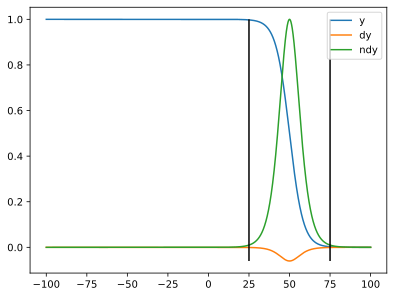

In [23]:
%config InlineBackend.figure_formats = ['svg']
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import scipy

def tanhmin(radius: np.array, eps: float) -> np.array:
    return 0.5 * (1.0 + np.tanh(-3.0 * radius / eps))
def norm(arr):
    ret = arr - np.min(arr)
    return ret / np.max(ret) 

r = 50
eps = 25
scale = 1

x = np.linspace(-100, 100, 10000)
dx = np.abs(x[0] - x[1])
y = tanhmin(x - r, eps) * scale

plt.figure()
plt.plot(x, y, label = "y")

dy = np.gradient(y, x)
plt.plot(x, dy, label="dy")

ndy = norm(np.abs(dy))
plt.plot(x, ndy, label="ndy")

indy = scipy.integrate.simpson(ndy, x)

#ilen = ndy[ndy >= 1e-1].shape[0] * dx
ilen = 2 * indy

tfit = lambda x, r, eps: tanhmin(x - r, eps)
popt, pcov = scipy.optimize.curve_fit(tfit, x, y / np.max(y))

print(popt, pcov)
ilen = popt[1]

print(ilen)

plt.vlines(x=r - ilen, ymin=np.min(dy), ymax=scale, color="black")
plt.vlines(x=r + ilen, ymin=np.min(dy), ymax=scale, color="black")

plt.legend()
plt.show()